In [1]:
import pandas as pd
import torch
from itertools import zip_longest

# local imports
from src.dataset import load_dataset
from src.train   import train_model
from src.models  import ATISMultiTaskModel as Model
from src.models  import SentenceEncoder as Encoder
from src.utils   import plot_metrics

import warnings
warnings.filterwarnings('ignore')

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Task 0: Data

In [2]:
train_ds, val_ds = load_dataset('data')

In [3]:

'''Demonstration purpose only'''

record = train_ds[5]
gt = record['gt']

words      = gt[1].split()

# pull out the first 12 of each
tokens     = record['input_ids'].tolist()[:12]
entities   = gt[2][:12]
entity_ids = record['slot_labels'].tolist()[:12] # type: ignore
mask       = record['attention_mask'].tolist()[:12]

# zip them together and print a table
header = f"{'Word':^15s} | {'TokenID':^7s} | {'Entity':^12s} | {'EntID':^6s} | {'Mask':^4s}"
print(header)
print("-" * len(header))
for w, t, e, eid, m in zip_longest(words, tokens, entities, entity_ids, mask, fillvalue="[PAD]"):
    print(f"{w:^15s} | {str(t):^7s} | {e:^12s} | {str(eid):^6s} | {str(m):^3s}")

     Word       | TokenID |    Entity    | EntID  | Mask
--------------------------------------------------------
       i        |  1045   |      X       |   5    |  1 
     need       |  2342   |      X       |   5    |  1 
       a        |  1037   |      X       |   5    |  1 
    flight      |  3462   |      X       |   5    |  1 
   tomorrow     |  4826   |   DateTime   |   9    |  1 
     from       |  2013   |      X       |   5    |  1 
   columbus     |  8912   |   Location   |   7    |  1 
      to        |  2000   |      X       |   5    |  1 
  minneapolis   |  11334  |   Location   |   7    |  1 
     [PAD]      |    0    |    [PAD]     |   0    |  0 
     [PAD]      |    0    |    [PAD]     |   0    |  0 
     [PAD]      |    0    |    [PAD]     |   0    |  0 


##### Dataset Overview

This project uses a **curated subset** of the Airline Travel Information System (ATIS) corpus. Each example consists of a user’s flight-related utterance, annotated with:

- **Intent**: the user’s overall goal (e.g. searching for flights, checking fares).  
- **Entities**: token-level labels indicating semantic categories (e.g. cities, times).

---

##### Example Record

```json
{
  "text":    "i need a flight tomorrow from columbus to minneapolis",
  "entities":["X","X","X","X","DateTime","X","Location","X","Location"],
  "intent":  "Flight"
}
```
---


Here:

- **text**: raw user utterance  
- **entities**: one tag per token ('X' = no entity)  
- **intent**: high-level query category  
> **Note:** `X` corresponds to 'other (uninteresting)' category.

##### Modeling Tasks

1. Intent Classification 
   - Build a classifier that takes an utterance and predicts its **intent** label.
   - 8 intent classes ('Fare', 'Meal', 'Capacity', 'FlightInfo', 'Location', 'Flight', 'Restriction', 'Schedule')

2. Named Entity Recognition (NER) 
   - Perform token-level labeling to assign each word in the utterance one of the **entity** tags.
   - 9 Entities ('X', 'Airline', 'Meal', 'Location', 'Modifier', 'DateTime', 'FlightDetails', 'Identifier', 'Price')


##### Dataset
The data set consists of below keys
- **input_ids**: the text tokenized using bert tokenizer consisting of a vocab of size 30522
- **attention_mask**: 1 where word valid 0 for padding
- **intent_label**: label encoded intent
- **slot_labels**: label encoded entities / slot

All sentences are padded to `100` while 0 represents padding for all positions except intent_label
> **Assumption**: BERT tokenizer adds special tokens ([CLS], [SEP]) which has been disabled and a naive `one-entity-per-word` is assumed. 

Note: "slot" and "entity" are synonymous in this codebase (I inherited 'slot' from the original data).


For additional filtering steps and exploratory data analysis, please see `notebooks/dataset.ipynb`.

## Task 1: Sentence Transformer Implementation

Below is a Transformer encoder similar to BERT’s backbone, plus a thin wrapper for sentence-level embeddings. it consists of 

- **Token Embedding** – maps input token IDs to dense vectors.
- **Positional Encoding** – adds sinusoidal position information.
- **Transformer Encoder Stack** – N identical layers of multi-head attention + feed-forward.
- **Sentence Encoder** – wraps the backbone and applies mean-pooling to produce fixed-size sentence vectors.


```Text
SentenceEncoder
└─ backbone: CustomEncoder
   ├─ Embedding (30,522 → <d_model>)
   ├─ PositionalEncoding (dropout=0.1)
   └─ TransformerEncoder (6× layers)
      └─ TransformerEncoderLayer (repeated 6×)
         ├─ MultiHeadAttention (<d_model> → <d_model>)
         ├─ FeedForward (<d_model> → 2048 → <d_model>)
         ├─ LayerNorm (ϵ=1e-5) ×2
         └─ Dropout (p=0.1) ×2
```

In [4]:
'''Demonstration purpose only'''

dims = [64, 32, 16]

input_ids      = record['input_ids'].unsqueeze(0).to(device)
attention_mask = record['attention_mask'].unsqueeze(0).to(device)

for d in dims:
    enc =  Encoder("custom", d).to(device)
    with torch.no_grad():
        e = enc(input_ids, attention_mask)
    
    # free v-ram/ram memory
    del enc
        
    print(f"{d}-dim encoder output shape: {e.shape}")

64-dim encoder output shape: torch.Size([1, 64])
32-dim encoder output shape: torch.Size([1, 32])
16-dim encoder output shape: torch.Size([1, 16])


## Task 2: Multi-Task Learning Expansion 

Below is a model that extends upon the earlier encoder backbone. Below are the additions 

- **intent_head**:
  - A simple feed-forward network to project the latent to intent.
  - Takes the pooled sentence embedding i.e the mean‐over‐tokens.
  - Shape (batch, d_model)
  - Sentence level Classification 
- **slot_head** 
  - To further contextualize token representations before labeling A `transformer block` to project the latent to entities/slot.
  - Takes the last layer hidden states from the backbone.
  - Shape (batch, seq_len, num_slots)
  - token-level classification


#### Loss
```python
loss_intent = CE(intent_logits, intent_labels)
loss_slot   = CE(slot_logits.view(-1, num_slots),
                 slot_labels.view(-1))
loss = (λ1 * loss_intent) + (λ2 * loss_slot)
```
Here λ1 and λ2 are relative weights, Where `λ2 > λ1` to prioritize improving token-level performance.


```Text

MultiTaskModel
└─ encoder: SentenceEncoder
|  └─ backbone: CustomEncoder
|     ├─ Embedding (30,522 → <d_model>)
|     ├─ PositionalEncoding (dropout=0.1)
|     └─ TransformerEncoder (6× layers)
|        └─ TransformerEncoderLayer (repeated 6×)
|           ├─ MultiHeadAttention (<d_model> → <d_model>)
|           ├─ FeedForward (<d_model> → 2048 → <d_model>)
|           ├─ LayerNorm (ϵ=1e-5) ×2
|           └─ Dropout (p=0.1) ×2
|
└─ intent_head: Linear(<d_model> → 8)
└─ slot_head:   Transformer
    ├─ TransformerEncoderLayer
    │  ├─ MultiHeadAttention (<d_model> → <d_model>)
    │  ├─ FeedForward (<d_model> → 2048 → <d_model>)
    │  ├─ LayerNorm (ϵ=1e-5) ×2
    │  └─ Dropout (p=0.2) ×2
    │
    └─ Linear (<d_model> → 10)

```

In [5]:
encoder =  Encoder("custom", 512).to(device)
model = Model(encoder).to(device)

In [ ]:
custom_metrics = train_model(train_ds, val_ds, model, epochs=10)


Epoch  0 | Train > Loss: 0.6948 | Intent Acc: 69.99% | Entity F1: 3.60% || Val   > Loss: 0.6226 | Intent Acc: 71.48% | Entity F1: 3.35%


Epoch  1 | Train > Loss: 0.5813 | Intent Acc: 73.15% | Entity F1: 2.47% || Val   > Loss: 0.5821 | Intent Acc: 71.48% | Entity F1: 3.35%


Epoch  2 | Train > Loss: 0.4162 | Intent Acc: 75.00% | Entity F1: 33.30% || Val   > Loss: 0.3135 | Intent Acc: 80.85% | Entity F1: 58.37%


Epoch  3 | Train > Loss: 0.2424 | Intent Acc: 84.42% | Entity F1: 62.55% || Val   > Loss: 0.2415 | Intent Acc: 84.76% | Entity F1: 63.54%


Epoch  4 | Train > Loss: 0.1998 | Intent Acc: 87.82% | Entity F1: 65.36% || Val   > Loss: 0.2183 | Intent Acc: 86.65% | Entity F1: 64.60%


Epoch  5 | Train > Loss: 0.1680 | Intent Acc: 90.85% | Entity F1: 68.48% || Val   > Loss: 0.2007 | Intent Acc: 88.55% | Entity F1: 69.85%


Epoch  6 | Train > Loss: 0.1536 | Intent Acc: 91.47% | Entity F1: 70.88% || Val   > Loss: 0.1870 | Intent Acc: 89.00% | Entity F1: 71.00%


Epoch  7 | Train > Loss: 0.1395 | Intent Acc: 92.92% | Entity F1: 72.60% || Val   > Loss: 0.1778 | Intent Acc: 90.00% | Entity F1: 72.35%


Epoch  8 | Train > Loss: 0.1312 | Intent Acc: 93.89% | Entity F1: 73.06% || Val   > Loss: 0.1798 | Intent Acc: 89.56% | Entity F1: 72.85%


Epoch  9 | Train > Loss: 0.1297 | Intent Acc: 93.43% | Entity F1: 73.83% || Val   > Loss: 0.1749 | Intent Acc: 89.89% | Entity F1: 73.16%


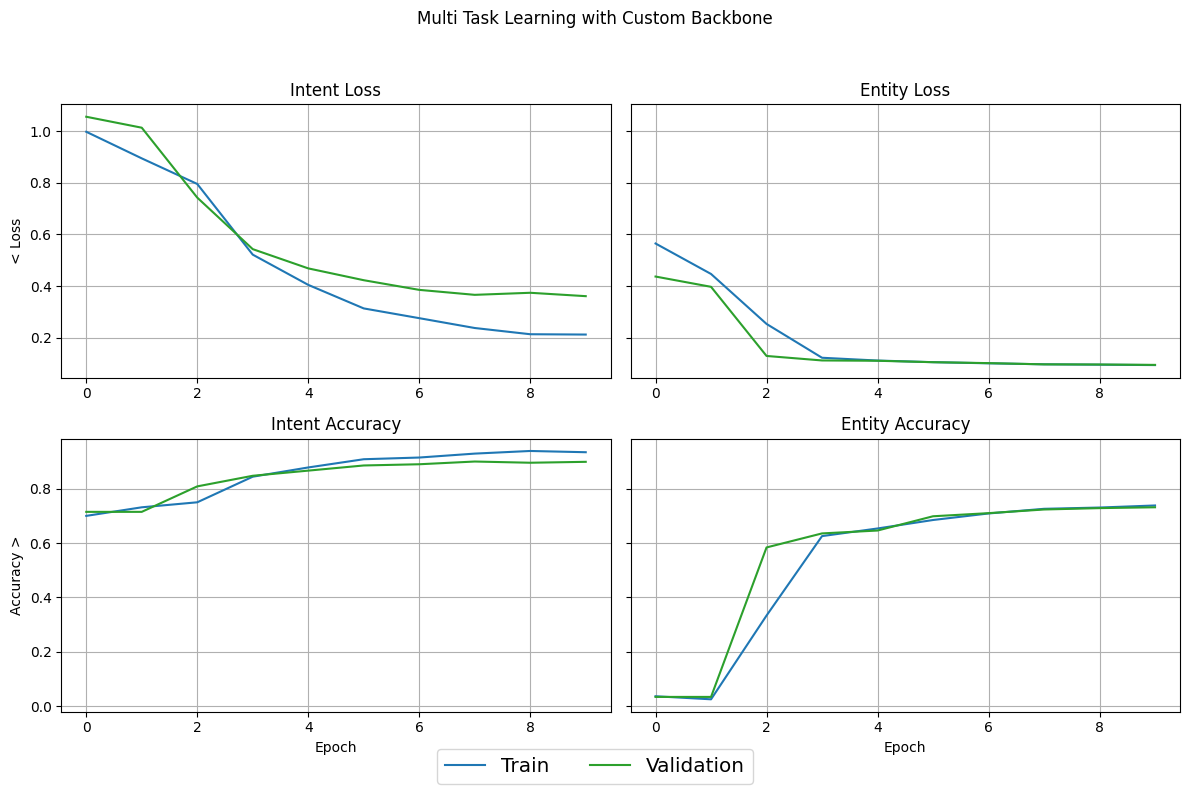

In [10]:
plot_metrics(custom_metrics, "Multi Task Learning with Custom Backbone")

### Task 3: Training Considerations 

##### **Scenario 1:** If the entire network should be frozen (no training)
**When to use:** 
- Zero-shot/inference only, no labeled data or compute budget for fine-tuning.
- The backbone pre-trained for this specific dataset.

**Advantages** 
- Removes the over head of training, works out of the box.
- No compute budget needed to training.
  
**Disadvantages** 
- Cannot adapt to domain shifts.
- No capacity to correct systematic errors of the pre-trained model for specific domain.
- Very limited use cases.


##### **Scenario 2:** If only the transformer backbone should be frozen (Freeze backbone, train only task heads).
**When to use:** 
- In most of the cases a foundational model / general purpose pre-trained model is used as a backbone.

**Advantages** 
- Removes the over head of training the massive backbone, only train the smaller projection layers.
- Has more flexibility to adapt to different task as long the dataset remains similar.
- Retains general language understanding of pre-trained backbone.  
- Enables faster experiments on head architectures.

**Disadvantages** 
- Cannot refine backbone to domain-specific patterns, accuracy may platue soon. 
- Limited capabilities for domain/task specific adaptation.
- May under-fit if head capacity alone is insufficient to correct pre-trained biases

##### **Scenario 3:** If only one of the task-specific heads (either for Task A or Task B) should be frozen.
**When to use:** 
- Strong multi-task imbalance: one loss reaches plateau long before the other.
- After reaching certain level of accuracy either of the heads can be frozen to focus more on the other task. 
- An training loop can be written that only trains the head with below threshold accuracy

**Advantages** 
- Focuses remaining capacity on the still-improving task.  
- May help focusing / simplifying multi task learning.


**Disadvantages**
- Will be very limited in capabilities for multi task, always good in one
- Introduces training complexity (dynamic freezing/unfreezing logic). 
- Can destabilize gradients, requires careful scheduling and possibly gradient clipping.
- Personally I don't see any reason to freeze heads, as this may free up gpu memory by a little but that portion will not be occupied for the current training. 


##### **Why transfer learning?**  
For tasks like these transfer learning makes a lot of sense as learning the embeddings from scratch will be very tough and time consuming. Also for larger corpus of data very tough. A sensible solution is have a pre-trained model as a backbone and then fine-tune the whole network if the task is very different or data is domain specific or transfer-learn last few layers or add additional heads to the backbone.

**Choice of pre-trained model:** 
- **BERT-base** (12 layers, 768 d_model): widely used encoder-only model, bi-directional attention, trained on BookCorpus + Wikipedia.

**Freeze/unfreeze strategy:**  
- **Option A (full fine-tune):** 
  - Unfreeze all layers 
  - Max adaptation when domain diverges.  
- **Option B (head-only):** 
  - Freeze backbone and train only heads 
  - Fastest and useful when compute-constrained.  
- **Option C (gradual unfreeze):** 
  - Start head-only
  - Then unfreeze last 2–4 encoder layers after head convergence.

**Rationale:**  
- Full fine-tune yields best performance when you have labels & VRAM.  
- Head-only reduces GPU memory and training time, good for prototyping.  
- Gradual unfreeze balances stability and adaptivity.


In [6]:
encoder = Encoder().to(device) # BERT pretrained
model   = Model(encoder).to(device)

Epoch  0 | Train > Loss: 0.4127 | Intent Acc: 79.30% | Entity F1: 43.33% || Val   > Loss: 0.1810 | Intent Acc: 90.11% | Entity F1: 74.52%


Epoch  1 | Train > Loss: 0.1184 | Intent Acc: 94.32% | Entity F1: 79.44% || Val   > Loss: 0.1007 | Intent Acc: 96.43% | Entity F1: 80.74%


Epoch  2 | Train > Loss: 0.0682 | Intent Acc: 98.13% | Entity F1: 82.57% || Val   > Loss: 0.0823 | Intent Acc: 97.10% | Entity F1: 83.50%


Epoch  3 | Train > Loss: 0.0492 | Intent Acc: 99.20% | Entity F1: 85.37% || Val   > Loss: 0.0755 | Intent Acc: 97.32% | Entity F1: 85.04%


Epoch  4 | Train > Loss: 0.0406 | Intent Acc: 99.22% | Entity F1: 87.01% || Val   > Loss: 0.0656 | Intent Acc: 97.32% | Entity F1: 86.97%


Epoch  5 | Train > Loss: 0.0340 | Intent Acc: 99.54% | Entity F1: 88.60% || Val   > Loss: 0.0594 | Intent Acc: 97.77% | Entity F1: 87.94%


Epoch  6 | Train > Loss: 0.0298 | Intent Acc: 99.72% | Entity F1: 89.73% || Val   > Loss: 0.0555 | Intent Acc: 97.77% | Entity F1: 88.60%


Epoch  7 | Train > Loss: 0.0268 | Intent Acc: 99.85% | Entity F1: 90.40% || Val   > Loss: 0.0538 | Intent Acc: 97.99% | Entity F1: 88.76%


Epoch  8 | Train > Loss: 0.0252 | Intent Acc: 99.89% | Entity F1: 90.96% || Val   > Loss: 0.0523 | Intent Acc: 98.21% | Entity F1: 89.23%


Epoch  9 | Train > Loss: 0.0242 | Intent Acc: 99.96% | Entity F1: 91.21% || Val   > Loss: 0.0523 | Intent Acc: 98.33% | Entity F1: 89.34%


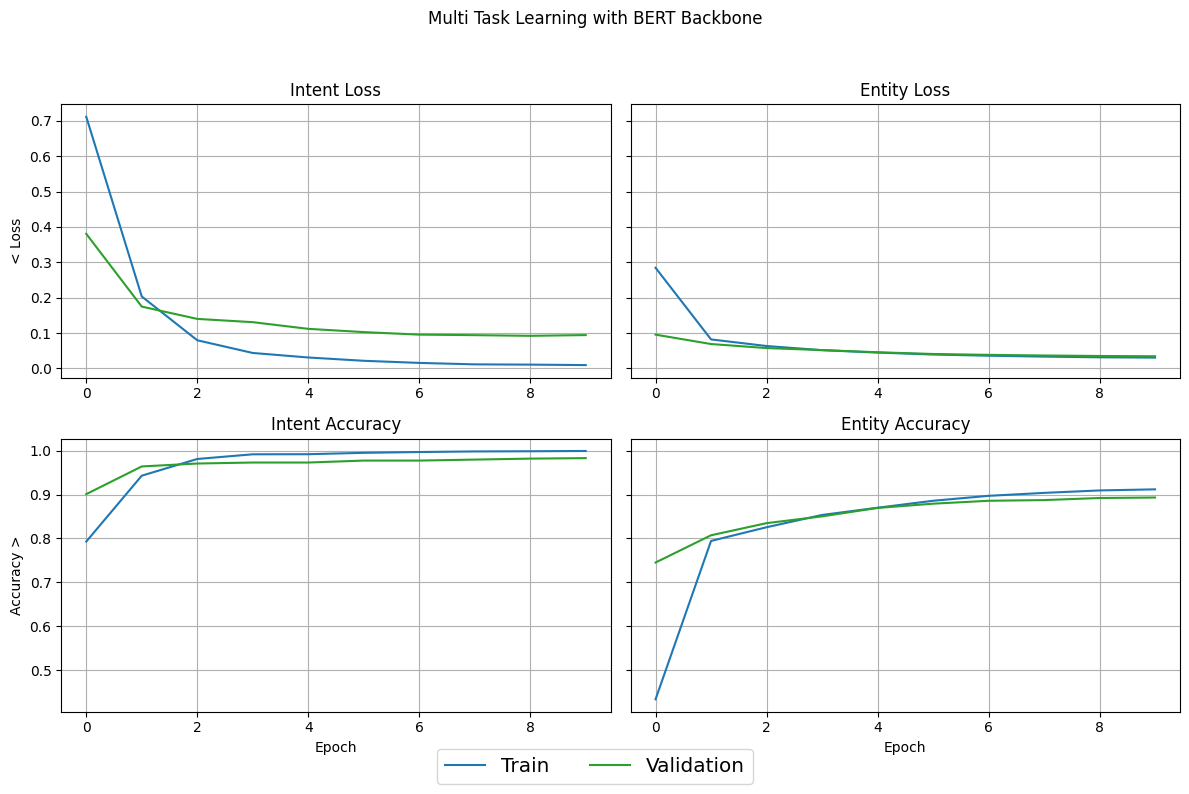

In [9]:
bert_metrics = train_model(train_ds, val_ds, model, epochs=10)
plot_metrics(bert_metrics, "Multi Task Learning with BERT Backbone")

### Task 4: Training Loop Implementation (BONUS)

### Metrics 

In [8]:
df = pd.DataFrame(custom_metrics)
df.round(2)

,train_loss,train_intent_loss,train_entity_loss,train_intent_acc,train_entity_f1,val_loss,val_intent_loss,val_entity_loss,val_intent_acc,val_entity_f1,epoch
0,0.69,1.00,0.56,0.70,0.04,0.62,1.06,0.44,0.71,0.03,0
1,0.58,0.89,0.45,0.73,0.02,0.58,1.01,0.40,0.71,0.03,1
2,0.42,0.80,0.25,0.75,0.33,0.31,0.74,0.13,0.81,0.58,2
3,0.24,0.52,0.12,0.84,0.63,0.24,0.54,0.11,0.85,0.64,3
4,0.20,0.40,0.11,0.88,0.65,0.22,0.47,0.11,0.87,0.65,4
5,0.17,0.31,0.11,0.91,0.68,0.20,0.42,0.11,0.89,0.70,5
6,0.15,0.28,0.10,0.91,0.71,0.19,0.39,0.10,0.89,0.71,6
7,0.14,0.24,0.10,0.93,0.73,0.18,0.37,0.10,0.90,0.72,7
8,0.13,0.21,0.10,0.94,0.73,0.18,0.37,0.10,0.90,0.73,8
9,0.13,0.21,0.09,0.93,0.74,0.17,0.36,0.10,0.90,0.73,9


In [9]:

plot_metrics(metrics)

NameError: name 'metrics' is not defined